In [10]:
import sys
sys.path.append('/Users/akash/personal/finance/market-regime/')


import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from models.autoencoder import Autoencoder
from models.contrastive_transformer import ContrastiveTransformer
from utils.config_loader import load_config
from models.storage import save_model, load_model
from torch.utils.tensorboard import SummaryWriter
import os
import modin as mpd
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset


In [7]:
import sys
import os

# Add the utils directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

import pandas as pd
import modin.pandas as mpd
from utils import clickhouse_data
import numpy as np
import talib
from sklearn.decomposition import PCA

# Define parameters
start_date = '2017-01-01'
end_date = '2025-12-31'

# Load and preprocess data
large_cap = clickhouse_data.clickhouse_largecap(start_date, end_date, size=1)
# mid_cap = clickhouse_data.clickhouse_midcap(start_date, end_date)
# small_cap = clickhouse_data.clickhouse_smallcap(start_date, end_date)

# # Fill missing dates
# large_cap = clickhouse_data.fill_missing_dates_modin_optimized(large_cap)
# mid_cap = clickhouse_data.fill_missing_dates_modin_optimized(mid_cap)
# small_cap = clickhouse_data.fill_missing_dates_modin_optimized(small_cap)

# Stack dataframes
all_cap = mpd.concat([large_cap])



    SELECT 
        financialinstrumentid,
        date,
        open,
        high,
        low,
        close,
        lastprice,
        previouscloseprice,
        volume,
        totaltradingvolume,
        totaltradevalue,
        totalnumberoftradesexecuted,
        tickersymbol,
        securityseries,
        settlementprice,
        financialinstrumentname
    FROM stock_data.tickers
    WHERE financialinstrumentid IN ('500002',) AND date BETWEEN '2017-01-01' AND '2025-12-31'
    ORDER BY financialinstrumentid, date ASC
    


In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

2025-03-02 23:54:00,900	INFO worker.py:1821 -- Started a local Ray instance.


In [8]:
import numpy as np
import pandas as pd
import talib
from prophet import Prophet

def extract_all_features(df):
    """
    Master function that:
    1. Retains raw OHLCV & additional trading data.
    2. Computes trend-based, volatility, liquidity, and microstructure features.
    3. Computes advanced technical indicators.
    4. Extracts seasonal components using Prophet.
    5. Ensures all feature columns are complete and normalized.
    """
    
    df = df.copy()

    # === Retain Raw Data for Reference ===
    raw_cols = [
        'date', 'open', 'high', 'low', 'close', 'lastprice', 'previouscloseprice',
        'volume', 'totaltradingvolume', 'totaltradevalue', 'totalnumberoftradesexecuted'
    ]
    df = df[raw_cols]  # Ensure we only work with the relevant columns

    # Ensure proper datetime format
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # === Compute Derived Features ===
    
    ## 🔹 Trend-Based Features
    df = clickhouse_data.compute_trend_features(df)

    ## 🔹 Volatility Features
    df = clickhouse_data.compute_volatility_features(df)

    ## 🔹 Liquidity Features (Includes Total Trading Volume & Trade Value)
    df = clickhouse_data.compute_liquidity_features(df)

    ## 🔹 Market Microstructure Features (VWAP, etc.)
    df = clickhouse_data.compute_microstructure_features(df)

    # === Derived Features from Additional Trading Data ===

    # 🔹 Previous Close Return (Gap Indicator)
    df['prev_close_return'] = np.log(df['close'] / df['previouscloseprice'])

    # 🔹 Trading Intensity (Total Trades / Volume)
    df['trading_intensity'] = df['totalnumberoftradesexecuted'] / df['totaltradingvolume']

    # 🔹 Turnover Ratio (Liquidity Proxy)
    df['turnover_ratio'] = df['totaltradevalue'] / df['totaltradingvolume']

    # 🔹 VWAP Ratio (Price Positioning)
    df['vwap_ratio'] = df['close'] / df['vwap']
    
    # 🔹 High-Low & Close-Open Ratios
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']

    # === Advanced Technical Indicators ===
    df['cci_20'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=20)
    df['williams_r'] = talib.WILLR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['stoch_k'], df['stoch_d'] = talib.STOCH(
        df['high'].values, df['low'].values, df['close'].values, 
        fastk_period=14, slowk_period=3, slowd_period=3
    )
    df['chande_momentum'] = talib.CMO(df['close'].values, timeperiod=14)
    df['ulcer_index'] = np.sqrt((df['close'].rolling(14).max().values - df['close'].values) ** 2 / 14)
    df['obv'] = talib.OBV(df['close'].astype(float).values, df['volume'].astype(float).values)
    df['chaikin_money_flow'] = talib.ADOSC(
        df['high'].astype(float).values, df['low'].astype(float).values, df['close'].astype(float).values, df['volume'].astype(float).values, 
        fastperiod=3, slowperiod=10
    )
    
    # === Extract Seasonality Features Using Prophet ===
    df_prophet = df[['close']].reset_index()
    df_prophet.columns = ['ds', 'y']

    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet.fit(df_prophet)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)

    df['seasonal_weekly'] = forecast['weekly']
    df['seasonal_yearly'] = forecast['yearly']
    
    # Fill missing values (if any)
    df = df.ffill()
    df.fillna(0, inplace=True)

    return df

featured_df = extract_all_features(all_cap)



Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
23:54:22 - cmdstanpy - INFO - Chain [1] start processing
23:54:23 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(AdvancedAutoencoder, self).__init__()
        
        # Encoder with deeper layers and non-linearity
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 8),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 8),
            nn.Linear(encoding_dim * 8, encoding_dim * 4),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 4),
            nn.Linear(encoding_dim * 4, encoding_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 2),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.Tanh()  # Non-linear bottleneck for better feature extraction
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 2),
            nn.Linear(encoding_dim * 2, encoding_dim * 4),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 4),
            nn.Linear(encoding_dim * 4, encoding_dim * 8),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 8),
            nn.Linear(encoding_dim * 8, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [18]:
# Load and scale data
scaler = StandardScaler()
X = featured_df.dropna().astype(np.float32)
X_scaled = scaler.fit_transform(X)
input_dim = X_scaled.shape[1]
encoding_dim = min(10, input_dim // 2)

# Convert data to PyTorch tensors (prevent look-ahead bias using a rolling window)
sequence_length = 5  # Define lookback window size
X_sequences = []
for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i + sequence_length])
X_sequences = np.array(X_sequences)

X_tensor = torch.tensor(X_sequences, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim, encoding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss(delta=1.0)

# Train autoencoder
epochs = 50
model.train()
for epoch in range(epochs):
    for batch in data_loader:
        batch_x = batch[0].to(device)
        optimizer.zero_grad()
        _, decoded = model(batch_x[:, -1, :])  # Use the last timestep to avoid look-ahead bias
        loss = criterion(decoded, batch_x[:, -1, :])
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Extract latent features
model.eval()
with torch.no_grad():
    X_encoded = model.encoder(X_tensor[:, -1, :].to(device)).cpu().numpy()

# Convert to DataFrame
encoded_features_df = pd.DataFrame(X_encoded, index=featured_df.index[sequence_length:])
print("✅ Simple Feature Extraction Complete!")
encoded_features_df.head()


Epoch [1/50], Loss: 0.9870
Epoch [2/50], Loss: 0.9448
Epoch [3/50], Loss: 0.9488
Epoch [4/50], Loss: 0.9530
Epoch [5/50], Loss: 0.9487
Epoch [6/50], Loss: 0.9547
Epoch [7/50], Loss: 0.9536
Epoch [8/50], Loss: 0.9546
Epoch [9/50], Loss: 0.9539
Epoch [10/50], Loss: 0.9576
Epoch [11/50], Loss: 0.9529
Epoch [12/50], Loss: 0.9538
Epoch [13/50], Loss: 0.9572
Epoch [14/50], Loss: 0.9555
Epoch [15/50], Loss: 0.9532
Epoch [16/50], Loss: 0.9559
Epoch [17/50], Loss: 0.9547
Epoch [18/50], Loss: 0.9570
Epoch [19/50], Loss: 0.9527
Epoch [20/50], Loss: 0.9528
Epoch [21/50], Loss: 0.9523
Epoch [22/50], Loss: 0.9554
Epoch [23/50], Loss: 0.9533
Epoch [24/50], Loss: 0.9536
Epoch [25/50], Loss: 0.9572
Epoch [26/50], Loss: 0.9522
Epoch [27/50], Loss: 0.9532
Epoch [28/50], Loss: 0.9523
Epoch [29/50], Loss: 0.9523
Epoch [30/50], Loss: 0.9542
Epoch [31/50], Loss: 0.9567
Epoch [32/50], Loss: 0.9557
Epoch [33/50], Loss: 0.9511
Epoch [34/50], Loss: 0.9584
Epoch [35/50], Loss: 0.9514
Epoch [36/50], Loss: 0.9522
E

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2017-07-03,2.043166,0.0,0.0,1.895864,4.126617,2.600553,0.0,0.0,0.0,2.024987
2017-07-04,1.393060,0.0,0.0,2.061598,4.433017,2.612196,0.0,0.0,0.0,0.876955
2017-07-05,1.504656,0.0,0.0,1.766328,4.164997,2.678627,0.0,0.0,0.0,1.405475
2017-07-06,1.436774,0.0,0.0,1.801389,4.086089,2.571608,0.0,0.0,0.0,1.166016
2017-07-07,1.398910,0.0,0.0,2.128043,4.714771,2.700781,0.0,0.0,0.0,0.770940


# GMM Features extractions and PCA's and t-SNE

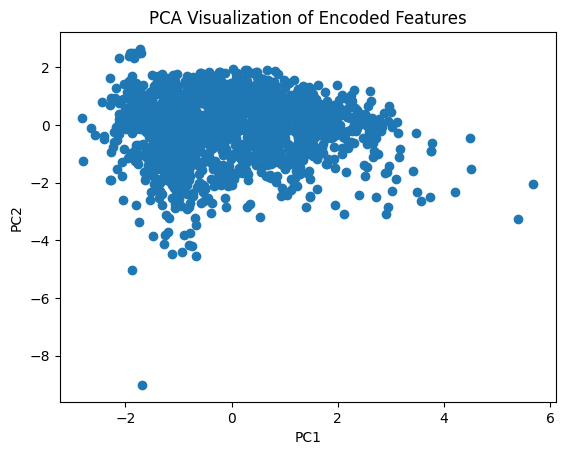

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(encoded_features_df)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Visualization of Encoded Features")
plt.show()


In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Fit GMM to find regimes
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(encoded_features_df)

# Fit K-Means for comparison
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(encoded_features_df)

encoded_features_df["gmm_regime"] = gmm_labels
encoded_features_df["kmeans_regime"] = kmeans_labels


In [21]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score (GMM):", silhouette_score(encoded_features_df, gmm_labels))
print("Silhouette Score (K-Means):", silhouette_score(encoded_features_df, kmeans_labels))
print("Davies-Bouldin Index (GMM):", davies_bouldin_score(encoded_features_df, gmm_labels))
print("Davies-Bouldin Index (K-Means):", davies_bouldin_score(encoded_features_df, kmeans_labels))


Silhouette Score (GMM): 0.2074837913043229
Silhouette Score (K-Means): 0.245757363291194
Davies-Bouldin Index (GMM): 1.5728650027411903
Davies-Bouldin Index (K-Means): 1.5287296992315325


In [22]:
featured_df.head()


,open,high,low,close,lastprice,previouscloseprice,volume,totaltradingvolume,totaltradevalue,totalnumberoftradesexecuted,...,cci_20,williams_r,stoch_k,stoch_d,chande_momentum,ulcer_index,obv,chaikin_money_flow,seasonal_weekly,seasonal_yearly
date,,,,,,,,,,,,,,,,,,,,,
2017-06-23,1500.35,1503.0,1430.20,1440.55,1440.55,1486.30,10963,10963,15950701,1256,...,0.0,0.0,0.0,0.0,0.0,0.0,10963.0,0.0,0.0,0.0
2017-06-27,1445.00,1457.0,1428.85,1442.95,1442.95,1440.55,9015,9015,13001118,1135,...,0.0,0.0,0.0,0.0,0.0,0.0,19978.0,0.0,0.0,0.0
2017-06-28,1443.00,1458.0,1425.80,1452.40,1452.40,1442.95,5662,5662,8171340,892,...,0.0,0.0,0.0,0.0,0.0,0.0,25640.0,0.0,0.0,0.0
2017-06-29,1458.00,1479.0,1435.00,1439.80,1439.80,1452.40,8416,8416,12287156,804,...,0.0,0.0,0.0,0.0,0.0,0.0,17224.0,0.0,0.0,0.0
2017-06-30,1419.25,1460.0,1411.25,1451.10,1451.10,1439.80,4764,4764,6900488,529,...,0.0,0.0,0.0,0.0,0.0,0.0,21988.0,0.0,0.0,0.0
